
# Improve Clustering in Homework 6

#### Chih-Yu Tung
#### Civil, Architectural and Environmental Engineering, Cockrell School of Engineering

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


## Executive Summary

k-Mean and DBSCAN have their own limitation to cluster datasets. K-Meam has a problem when the dataset is not               spherical and DBSCAN has a problem when the dataset is too close to each other. Thus, I want to find a general             cluster method that can cluster homework 6 well. 
        
I tried 3 new clustering methods, Gaussian Mixture, Bayesian Gaussian Mixture, and Agglomerative. I noticed that Gaussian Mixture clustering method can work very well in homework 6 if we can find a suitable number of clusters by elbow method. Furthermore, Bayesian Gaussian Mixture can automatically find a suitable number of clusters during its cluster process, but the number maybe not correct. Besides, Agglomerative method, hierarchical clustering, can also work well in homework 6 but it needs more sophisticated decision. 

## Import Packages

We need some standard packages and libraries to be installed with Anaconda 3.

In [1]:
import geostatspy.GSLIB as GSLIB                      # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                # GSLIB methods convert to Python       

import numpy as np                                    # ndarrys for gridded data
import pandas as pd                                   # DataFrames for tabular data
import os                                             # set working directory, run executables
os.environ["OMP_NUM_THREADS"] = '1'                   # avoid k-Meam leakage information
import matplotlib.pyplot as plt                       # for plotting
import copy                                           # for deep copies
from sklearn.neighbors import NearestNeighbors        # nearest neighbours function to calculate eps hyperparameter
from sklearn.preprocessing import MinMaxScaler        # min/max normalization
from sklearn.cluster import KMeans                    # k-means clustering
from sklearn.cluster import DBSCAN                    # DBSCAN clustering
from sklearn.cluster import SpectralClustering        # spectral clustering

import matplotlib.cm as cm                                       # for plot color map
import matplotlib.colors as mcolors                              # for find the color from the plot

from sklearn.mixture import GaussianMixture                      # Gaussian Mixture clustering
from sklearn.mixture import BayesianGaussianMixture              # Bayesian Gaussian Mixture clustering

from time import time                                            # time measure
from scipy.cluster.hierarchy import linkage                      # calculate distance for hierachical/ agglomerative clustering
from scipy.cluster.hierarchy import dendrogram                   # diagram representing a tree
from scipy.cluster.hierarchy import fcluster                     # form flat clusters from hierachical/ agglomerative clustering
from sklearn.metrics.cluster import adjusted_mutual_info_score   # adjusted mutual information between two clusterings
from sklearn.cluster import AgglomerativeClustering              # Agglomerative clustering

## Functions

In [2]:
# Vistualize clustering for Agglomerative clusering method
def plot_clustering(X, labels, title = None):
    plt.scatter(X[:, 0], X[:, 1], c = labels, alpha = 0.4, linewidths = 1.0, 
                edgecolors = 'black',cmap = plt.cm.inferno)
    if title is not None:
        plt.title(title, size = 17)
#     plt.axis('off')
    plt.tight_layout()

## Load Data
#### For Data 1: nonlinear_facies_v2.csv

In [3]:
df_nonlinear = pd.read_csv('nonlinear_facies_v2.csv')    # load nonlinear_facies_v2.csv table
df_nonlinear.head()

,Unnamed: 0,Por,AI,Facies
0,0,8.980678,381.296221,3
1,1,10.135657,304.449932,3
2,2,16.150132,193.607906,3
3,3,13.696509,205.778123,3
4,4,13.132821,290.854794,3


#### For Data 2: sample_data_Gaussian_mixture_v1.csv

In [4]:
df_sample = pd.read_csv('sample_data_Gaussian_mixture_v1.csv')    # load sample_data_Gaussian_mixture_v1.csv table
df_sample.head()

,Unnamed: 0,Por,AI,Facies
0,0,17.380049,2942.043321,0
1,1,17.473773,2862.323981,0
2,2,16.874080,2843.042816,0
3,3,17.117432,2880.817908,0
4,4,16.591956,2864.390218,0


## Convenient Variables

In [5]:
col = ['AI','Por','Facies']
units = ['kg/m2*10^3','%']
xlim_nonlinear = [0,1200]
xlim_sample = [0,7000]
ylim = [0,30]
xlabel = 'Acoustic Impedance (kg/m^2s*10^3)'
ylabel = 'Porosity (%)'

## Summary Statistics for Tabular Data
Normalize the datas and show the 10, 50 and 90 percent values.
#### For Data 1: nonlinear_facies_v2.csv

In [6]:
transform = MinMaxScaler(); 
features = [col[0],col[1]]

# standardize the data features to mean = 0, var = 1.0
df_nonlinear['n' + col[0]] = transform.fit_transform(df_nonlinear.loc[:,features].values)[:,0]
# standardize the data features to mean = 0, var = 1.0
df_nonlinear['n' + col[1]] = transform.fit_transform(df_nonlinear.loc[:,features].values)[:,1] 

df_nonlinear.describe(percentiles = [0.1, 0.5, 0.9]).transpose()

,count,mean,std,min,10%,50%,90%,max
Unnamed: 0,1800.0,205.055556,137.362381,0.0,35.900000,179.500000,409.100000,499.0
Por,1800.0,17.122778,4.778704,0.0,10.859917,17.674606,22.567225,30.0
AI,1800.0,625.522917,247.547997,10.0,184.848396,683.865824,878.235655,1200.0
Facies,1800.0,1.666667,0.816723,1.0,1.000000,1.000000,3.000000,3.0
nAI,1800.0,0.517246,0.208024,0.0,0.146931,0.566274,0.729610,1.0
nPor,1800.0,0.570759,0.159290,0.0,0.361997,0.589154,0.752241,1.0


#### For Data 2: sample_data_Gaussian_mixture_v1.csv

In [7]:
transform = MinMaxScaler(); 
features = [col[0],col[1]]

# standardize the data features to mean = 0, var = 1.0
df_sample['n' + col[0]] = transform.fit_transform(df_sample.loc[:,features].values)[:,0]
# standardize the data features to mean = 0, var = 1.0
df_sample['n' + col[1]] = transform.fit_transform(df_sample.loc[:,features].values)[:,1]

df_sample.describe(percentiles = [0.1, 0.5, 0.9]).transpose()

,count,mean,std,min,10%,50%,90%,max
Unnamed: 0,477.0,36.610063,24.204463,0.000000,6.000000,34.000000,71.400000,96.000000
Por,477.0,14.479310,2.965744,8.938189,10.410045,16.081174,17.843565,19.135287
AI,477.0,4494.903124,1357.239351,2590.765673,2795.519436,4681.938249,6519.906054,6907.353438
Facies,477.0,2.932914,2.186597,0.000000,0.000000,3.000000,6.000000,6.000000
nAI,477.0,0.441121,0.314424,0.000000,0.047434,0.484450,0.910242,1.000000
nPor,477.0,0.543402,0.290842,0.000000,0.144341,0.700492,0.873325,1.000000


## Visualization Datas
### Set up Colors to Make Scatter and Histogram Plots have the same Color in the Items
#### For Data 1: nonlinear_facies_v2.csv

In [8]:
n_nonlinear = len(list(set(df_nonlinear['Facies'])))   # set n colors by the number of the Facies

cmap = cm.get_cmap('inferno', n_nonlinear)  # matplotlib color palette name, n colors
cmap_color_nonlinear = []
for i in range(cmap.N):
    rgb = cmap(i)[:n_nonlinear]  # will return rgba, we take only first K value so we get rgb
    cmap_color_nonlinear.append(mcolors.rgb2hex(rgb))

cmap = plt.cm.inferno   # set color map

#### For Data 2: sample_data_Gaussian_mixture_v1.csv

In [9]:
n_sample = len(list(set(df_sample['Facies'])))   # set n colors by the number of the Facies

cmap = cm.get_cmap('inferno', n_sample)  # matplotlib color palette name, n colors
cmap_color_sample = []
for i in range(cmap.N):
    rgb = cmap(i)[:n_sample]  # will return rgba, we take only first K value so we get rgb
    cmap_color_sample.append(mcolors.rgb2hex(rgb))

cmap = plt.cm.inferno

### Scatter Plot of Original and Normalized Data, and Histogram of  Dataset Group Proportions
#### For Data 1: nonlinear_facies_v2.csv

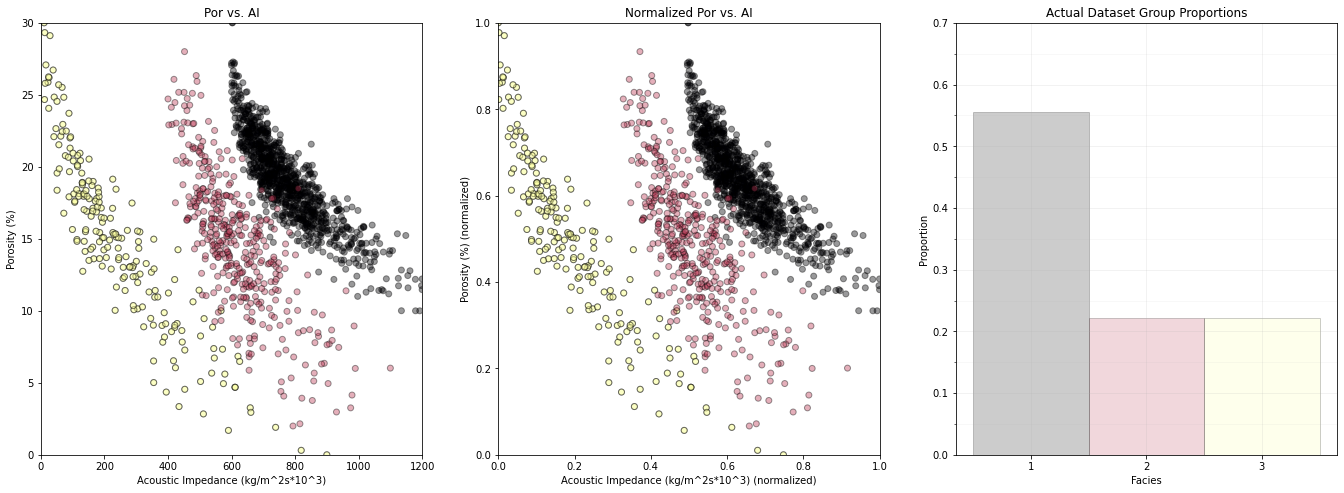

In [10]:
# plot our data  
plt.subplot(131)
plt.scatter(df_nonlinear[col[0]], df_nonlinear[col[1]], c = df_nonlinear['Facies'],
            alpha = 0.4, linewidths = 1.0, edgecolors = 'black', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim_nonlinear)
plt.ylim(ylim)

plt.subplot(132)
plt.scatter(df_nonlinear['n' + col[0]], df_nonlinear['n' + col[1]], c = df_nonlinear['Facies'],
            alpha = 0.4, linewidths = 1.0, edgecolors = 'black', cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0])
plt.xlabel(xlabel + ' (normalized)')
plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 2.0, top = 1.0, wspace = 0.2, hspace = 0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df_nonlinear['Facies'], alpha = 0.2,edgecolor = "black",
                             bins = np.arange(0.5, 1.5 + n_nonlinear, 1), range = [0.5, 0.5 + n_nonlinear],
                             density = True)

patches[0].set_facecolor(str(cmap_color_nonlinear[0]))
patches[1].set_facecolor(str(cmap_color_nonlinear[1]))
patches[2].set_facecolor(str(cmap_color_nonlinear[2]))

plt.title('Actual Dataset Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(1.0, 1.0 + n_nonlinear, 1))
ax.set_yticks(np.arange(0, 0.75, 0.05), minor=True)

ax.grid(which = 'minor', alpha = 0.1)
ax.grid(which = 'major', alpha = 0.2)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.0, top = 1.50, wspace = 0.2, hspace = 0.2)

#### For Data 2: sample_data_Gaussian_mixture_v1.csv

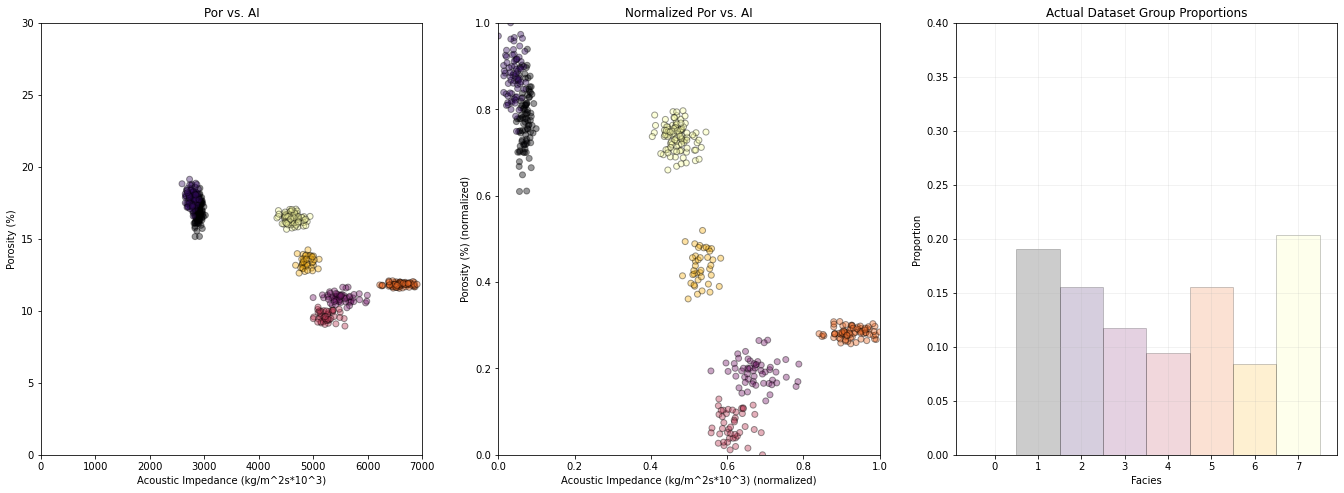

In [11]:
# plot our data  
plt.subplot(131)
plt.scatter(df_sample[col[0]], df_sample[col[1]], c = df_sample['Facies'] + 1,
            alpha = 0.4, linewidths = 1.0, edgecolors = 'black', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim_sample)
plt.ylim(ylim)

plt.subplot(132)
plt.scatter(df_sample['n' + col[0]], df_sample['n' + col[1]], c = df_sample['Facies'] + 1,
            alpha = 0.4, linewidths = 1.0, edgecolors = 'black', cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0])
plt.xlabel(xlabel + ' (normalized)')
plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 2.0, top = 1.0, wspace = 0.2, hspace = 0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df_sample['Facies'] + 1, alpha = 0.2, edgecolor = 'black',
                             bins = np.arange(-0.5, 1.5 + n_sample, 1), range = [0.5, 0.5 + n_sample],
                             density = True)

patches[1].set_facecolor(str(cmap_color_sample[0])); patches[2].set_facecolor(str(cmap_color_sample[1]));
patches[3].set_facecolor(str(cmap_color_sample[2])); patches[4].set_facecolor(str(cmap_color_sample[3]));
patches[5].set_facecolor(str(cmap_color_sample[4])); patches[6].set_facecolor(str(cmap_color_sample[5]));
patches[7].set_facecolor(str(cmap_color_sample[6]));

plt.title('Actual Dataset Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(0, 1.0 + n_sample, 1))
ax.set_yticks(np.arange(0, 0.45, 0.05), minor = True)

ax.grid(which = 'minor', alpha = 0.1)
ax.grid(which = 'major', alpha = 0.2)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.0, top = 1.50, wspace = 0.2, hspace = 0.2)

## Clustering Review (k-Mean and DBSCAN)
### k-Mean Parameter Estimation
If we use k-Mean method to cluster data and don't know the actual cluster number, we can apply elbow method to determine it. 
The immediate measure for evaluating k-Mean clustering is inertia: the sum of the squared distances between each point and its nearest cluster center.

The elbow point is a good starting point, but we still need to test values around it.

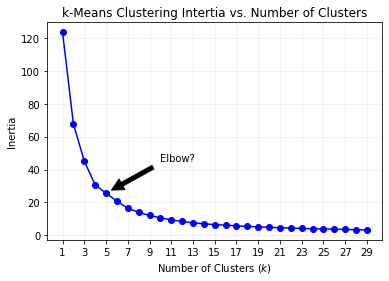

The acutlal clustering number is 3.


In [12]:
inertias = []
ks = range(1,30)
for i in ks:
    km = KMeans(n_clusters = i , random_state = 0)
    km.fit(df_nonlinear[['n' + col[0],'n' + col[1]]].values)
    inertias.append(km.inertia_)

plt.plot(ks, inertias, 'o-', c = 'b')
plt.annotate('Elbow?',
             xy = (5, inertias[4]),
             xytext = (10, inertias[2]),
             arrowprops = {'facecolor':'black','shrink':0.1})

plt.title('k-Means Clustering Intertia vs. Number of Clusters')
plt.xlabel('Number of Clusters ($k$)')
plt.ylabel('Inertia')
ax = plt.gca()
ax.set_xticks(np.arange(1.0, 30.1, 2))
ax.grid(which = 'major', alpha = 0.2)

plt.show()

print('The acutlal clustering number is 3.')

### k-Mean Clustering
The k-Mean method cannot work well if the data distribution is not spherical (Data 1: nonlinear_facies_v2.csv) because the method clusters data by a certain distance.

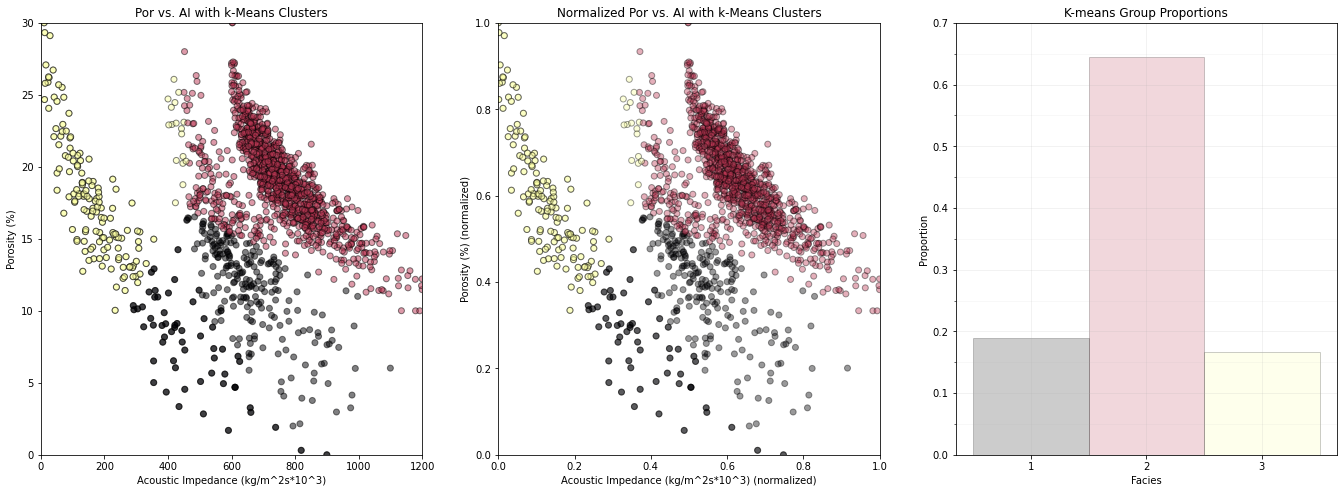

The non-convex, nonlinear shapes, and low-density representation of edges of clusters are not captured well.


In [13]:
kmeans = KMeans(n_clusters = n_nonlinear, random_state=0).fit(df_nonlinear[['n' + col[0],'n' + col[1]]].values)
df_nonlinear['kMeans'] = kmeans.labels_ + 1

plt.subplot(131)                          
plt.scatter(df_nonlinear[col[0]], df_nonlinear[col[1]], c = df_nonlinear['kMeans'], 
            alpha = 0.5, edgecolor ='black', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with k-Means Clusters')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim_nonlinear)
plt.ylim(ylim)

plt.subplot(132)                          
plt.scatter(df_nonlinear['n' + col[0]], df_nonlinear['n' + col[1]], c = df_nonlinear['kMeans'],
            alpha = 0.4, linewidths = 1.0, edgecolors = 'black', cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with k-Means Clusters')
plt.xlabel(xlabel + ' (normalized)')
plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.2, top = 1.2, wspace = 0.2, hspace = 0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df_nonlinear['kMeans'], alpha = 0.2, edgecolor = 'black', 
                             bins = np.arange(0.5, 1.5 + n_nonlinear, 1), range = [0.5, 0.5 + n_nonlinear], 
                             density = True)

patches[0].set_facecolor(str(cmap_color_nonlinear[0])); patches[1].set_facecolor(str(cmap_color_nonlinear[1])); 
patches[2].set_facecolor(str(cmap_color_nonlinear[2]));

plt.title('K-means Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(1.0, 1.0 + n_nonlinear, 1))
ax.set_yticks(np.arange(0, 0.75, 0.05), minor=True)

ax.grid(which = 'minor', alpha=0.1)
ax.grid(which = 'major', alpha=0.2)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.0, top = 1.50, wspace = 0.2, hspace = 0.2)

plt.show()

print('The non-convex, nonlinear shapes, and low-density representation of edges of clusters are not captured well.')

### DBSCAN Parameter Estimation
If we use DBSCAN method to cluster data and don't know the actual cluster number, we can calculate the nearest neighbor distance in normalized feature space for all the sample data and plot it in ascending order. After that, select the distance that maximizes the positive curvature, kind of elbow point. 

The elbow point is a good starting point, but we still need to test values around it.

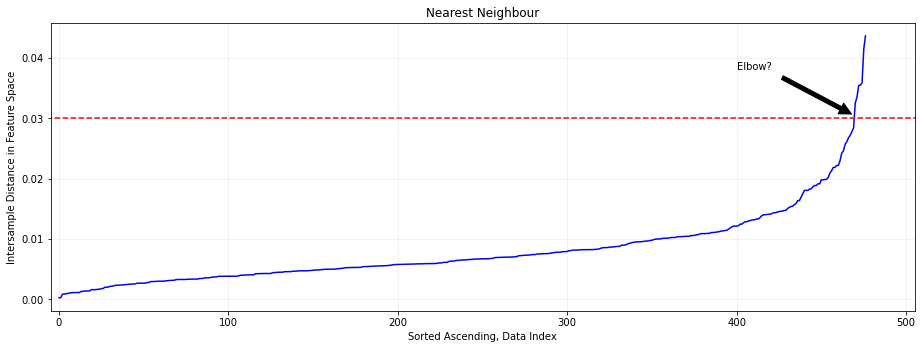

In [14]:
neigh = NearestNeighbors(n_neighbors = 2, radius = 999.0, algorithm='kd_tree')
nbrs = neigh.fit(df_sample[['n' + col[0],'n' + col[1]]].values)
distances, indices = nbrs.kneighbors(df_sample[['n' + col[0],'n' + col[1]]].values)
distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.plot(distances, c = 'b')
plt.xlabel('Sorted Ascending, Data Index')
plt.ylabel('Intersample Distance in Feature Space')
plt.title('Nearest Neighbour')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.00, wspace=0.2, hspace=0.2)
plt.xlim(-5, 505)
ax = plt.gca()
ax.set_xticks(np.arange(0, 500.1, 100))
ax.grid(which = 'major', alpha = 0.2)

x = np.linspace(-100, 600 , 100)
y = x * 0 + 0.03
plt.plot(x, y, color = 'r', linestyle = 'dashed')
plt.annotate('Elbow?',
             xy = (473, 0.0299),
             xytext = (400, 0.038),
             arrowprops = {'facecolor':'black','shrink':0.1})

plt.show()

### DBSCAN Clustering
The DBSCAN method cannot work well if the data distribution is too close (Data 2: sample_data_Gaussian_mixture_v1.csv) because the method clusters data by a sufficient point density.

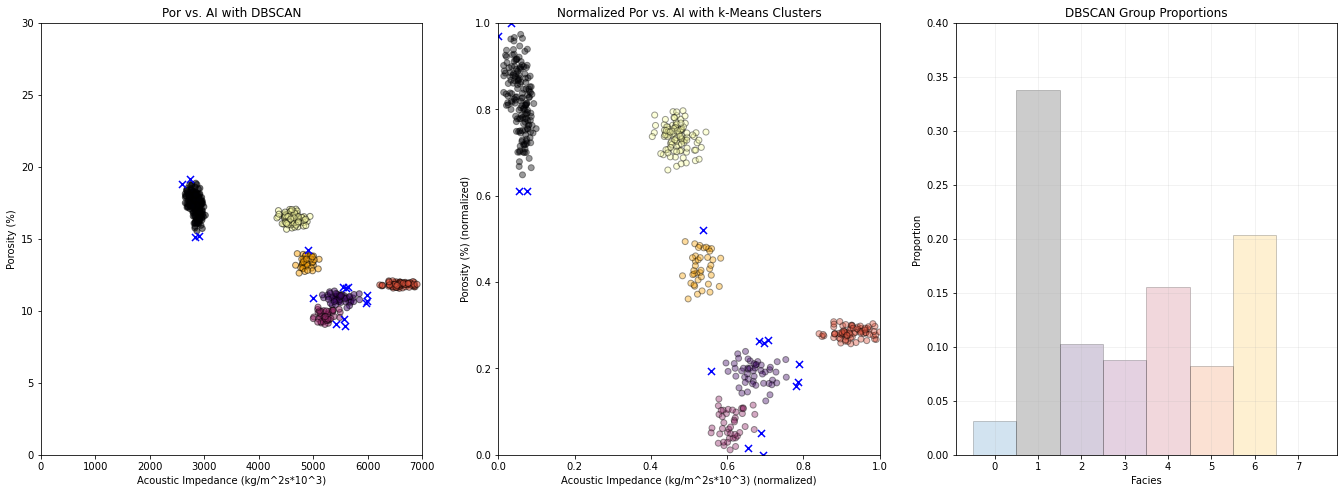

The too-crowded data distribution cannot be split well. Only can split 6 clustering.


In [15]:
dbscan = DBSCAN(eps = 0.032, min_samples = 5).fit(df_sample[['n' + col[0],'n' + col[1]]].values)
df_sample['DBSCAN'] = dbscan.labels_ + 1

plt.subplot(131)                          # plot the assigned training data and K prototypes
df_in = df_sample.loc[(df_sample['DBSCAN'] != 0)]
plt.scatter(df_in[col[0]], df_in[col[1]], c = df_in['DBSCAN'], alpha = 0.5, edgecolor = 'black', cmap = cmap)
df_outlier = df_sample.loc[(df_sample['DBSCAN'] == 0)]
plt.scatter(df_outlier[col[0]], df_outlier[col[1]], c ='blue',s = 50, marker = 'x', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with DBSCAN')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim_sample)
plt.ylim(ylim)

plt.subplot(132)                          # plot the training data and K prototypes
plt.scatter(df_in['n' + col[0]], df_in['n' + col[1]], c = df_in['DBSCAN'], alpha = 0.4, 
            linewidths = 1.0, edgecolors = "black", cmap = cmap)
plt.scatter(df_outlier['n' + col[0]], df_outlier['n' + col[1]], c = 'blue', s = 50, marker = 'x', cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with k-Means Clusters')
plt.xlabel(xlabel + ' (normalized)')
plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.2, top = 1.2, wspace = 0.2, hspace = 0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df_sample['DBSCAN'], alpha = 0.2, edgecolor = 'k',
                             bins = np.arange(-0.5, 1.5 + n_sample, 1),
                             range = [-0.5, 0.5 + n_sample], density = True)

patches[1].set_facecolor(str(cmap_color_sample[0])); patches[2].set_facecolor(str(cmap_color_sample[1]));
patches[3].set_facecolor(str(cmap_color_sample[2])); patches[4].set_facecolor(str(cmap_color_sample[3])); 
patches[5].set_facecolor(str(cmap_color_sample[4])); patches[6].set_facecolor(str(cmap_color_sample[5]));
patches[7].set_facecolor(str(cmap_color_sample[6]));

plt.title('DBSCAN Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(0.0, 1.0 + n_sample, 1))
ax.set_yticks(np.arange(0, 0.45, 0.05), minor=True)

ax.grid(which = 'minor', alpha = 0.1)
ax.grid(which = 'major', alpha = 0.2)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.0, top = 1.50, wspace = 0.2, hspace = 0.2)

plt.show()

print('The too-crowded data distribution cannot be split well. Only can split 6 clustering.')

## Introduce New Clustering
## 1. Gaussian Mixture Clustering Method
Gaussian Mixture method supposes there are some number of Gaussian distributions, and each distribution represents a cluster.

### Gaussian Mixture Clustering Parameter Estimation
Refer from scikit learn: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

For sklearn.mixture.GaussianMixture (n_components = 1, *, covariance_type = 'full', tol = 0.001, reg_covar = 1e-06, max_iter = 100, n_init = 1, init_params = 'kmeans', weights_init = None, means_init = None, precisions_init = None, random_state = None, warm_start = False, verbose = 0, verbose_interval = 10)

* n_componentsint: The number of mixture components (default = 1).
* random_stateint: RandomState instance or None (default = None).
* covariance_type: String describing the type of covariance parameters to use (default = ’full’).
        -full: each component has its own general covariance matrix.
        -tied: all components share the same general covariance matrix.
        -diag: each component has its own diagonal covariance matrix.
        -spherical: each component has its own single variance.
    
With k-Means, we could use the inertia or silhouette score to select the appropriate number of clusters (n_componentsint). But with Gaussian Mixture, it’s not possible to use these metrics because they are not reliable when clusters are not spherical or have different sizes. Instead we can try to find the model that minimizes a theoretical information criterion, such as “Akaike information criterion (AIC)” or “bayesian information criterion (BIC)”.

The elbow point is a good starting point, but we still need to test values around it.
#### For Data 1: nonlinear_facies_v2.csv

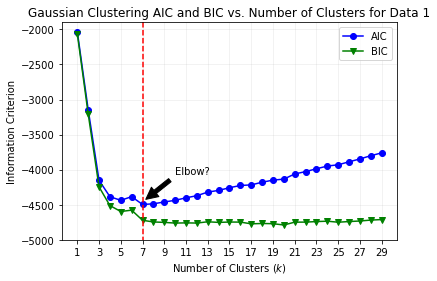

The acutlal clustering number is 3.


In [16]:
sum_aic = []
sum_bic = []

gs = range(1,30)
for j in gs:
    gmm = GaussianMixture(n_components = j, random_state = 0)
    gmm = gmm.fit(df_nonlinear[['n' + col[0],'n' + col[1]]].values)
    sum_aic.append(gmm.bic(df_nonlinear[['n' + col[0],'n' + col[1]]].values))
    sum_bic.append(gmm.aic(df_nonlinear[['n' + col[0],'n' + col[1]]].values))
    
plt.plot(gs, sum_aic, 'o-', c = 'b', label = "AIC")
plt.plot(gs, sum_bic, 'v-', c = 'g', label = "BIC")


x = y * 0 + 7
y = np.linspace(-1900, -5000 , 100)
plt.plot(x, y, color = 'r', linestyle = 'dashed')
plt.annotate('Elbow?',
             xy = (7, sum_aic[8]),
             xytext = (10, sum_aic[20]),
             arrowprops = {'facecolor':'black','shrink':0.1})

plt.legend(loc = 'best')
plt.title('Gaussian Clustering AIC and BIC vs. Number of Clusters for Data 1')
plt.xlabel('Number of Clusters ($k$)')
plt.ylabel('Information Criterion')
ax = plt.gca()
ax.set_xticks(np.arange(1.0, 30.1, 2))
ax.grid(which = 'major', alpha = 0.2)
plt.ylim(-5000, -1900)

plt.show()

print('The acutlal clustering number is 3.')

#### For Data 2: sample_data_Gaussian_mixture_v1.csv

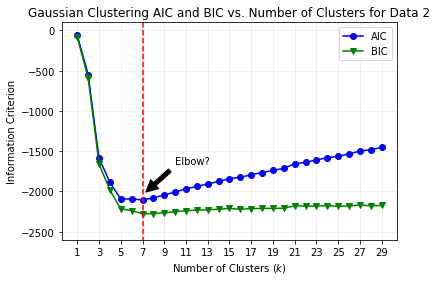

The acutlal clustering number is 7.


In [17]:
sum_aic = []
sum_bic = []

gs = range(1,30)
for j in gs:
    gmm = GaussianMixture(n_components = j, random_state = 0)
    gmm = gmm.fit(df_sample[['n' + col[0],'n' + col[1]]].values)
    sum_aic.append(gmm.bic(df_sample[['n' + col[0],'n' + col[1]]].values))
    sum_bic.append(gmm.aic(df_sample[['n' + col[0],'n' + col[1]]].values))
    
plt.plot(gs, sum_aic, 'o-', c = 'b', label = "AIC")
plt.plot(gs, sum_bic, 'v-', c = 'g', label = "BIC")


x = y * 0 + 7
y = np.linspace(100, -2600 , 100)
plt.plot(x, y, color = 'r', linestyle = 'dashed')
plt.annotate('Elbow?',
             xy = (7, sum_aic[8]),
             xytext = (10, sum_aic[20]),
             arrowprops = {'facecolor':'black','shrink':0.1})

plt.legend(loc = 'best')
plt.title('Gaussian Clustering AIC and BIC vs. Number of Clusters for Data 2')
plt.xlabel('Number of Clusters ($k$)')
plt.ylabel('Information Criterion')
ax = plt.gca()
ax.set_xticks(np.arange(1.0, 30.1, 2))
ax.grid(which = 'major', alpha = 0.2)
plt.ylim(-2600, 100)

plt.show()

print('The acutlal clustering number is 7.')

### Gaussian Mixture Clustering
#### For Data 1: nonlinear_facies_v2.csv

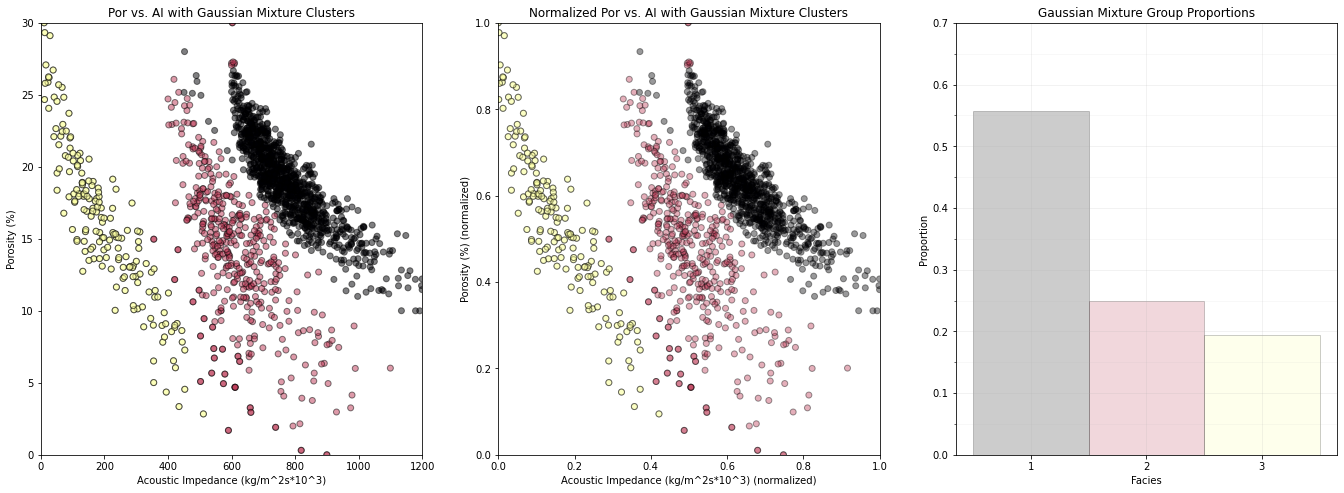

The Gaussian Mixture method clusters the strip distribution data well.
However, the data around the boundary is still challenging to cluster correctly.


In [18]:
gmm = GaussianMixture(n_components = n_nonlinear, random_state = 0).fit(df_nonlinear[['n' + col[0],'n' + col[1]]].values)
gmm_labels = gmm.predict(df_nonlinear[['n' + col[0],'n' + col[1]]].values)
df_nonlinear['gmm'] = gmm_labels + 1

plt.subplot(131)                          
plt.scatter(df_nonlinear[col[0]], df_nonlinear[col[1]], c = df_nonlinear['gmm'],
            alpha = 0.5, edgecolor = 'k', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with Gaussian Mixture Clusters')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim_nonlinear)
plt.ylim(ylim)

plt.subplot(132)                          
plt.scatter(df_nonlinear['n' + col[0]], df_nonlinear['n' + col[1]], c = df_nonlinear['gmm'], 
            alpha = 0.4, linewidths = 1.0, edgecolors = 'black', cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with Gaussian Mixture Clusters')
plt.xlabel(xlabel + ' (normalized)')
plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.2, top = 1.2, wspace = 0.2, hspace = 0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df_nonlinear['gmm'], alpha=0.2, edgecolor = 'black', 
                             bins=np.arange(0.5, 1.5 + n_nonlinear, 1), range = [0.5, 0.5 + n_nonlinear],
                             density = True)

patches[0].set_facecolor(str(cmap_color_nonlinear[0]))
patches[1].set_facecolor(str(cmap_color_nonlinear[1]))
patches[2].set_facecolor(str(cmap_color_nonlinear[2]))

plt.title('Gaussian Mixture Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(1.0, 1.0 + n_nonlinear, 1))
ax.set_yticks(np.arange(0, 0.75, 0.05), minor = True)

ax.grid(which = 'minor', alpha = 0.1)
ax.grid(which = 'major', alpha = 0.2)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.0, top = 1.50, wspace = 0.2, hspace = 0.2)

plt.show()

print('The Gaussian Mixture method clusters the strip distribution data well.\
\nHowever, the data around the boundary is still challenging to cluster correctly.')

#### For Data 2: sample_data_Gaussian_mixture_v1.csv

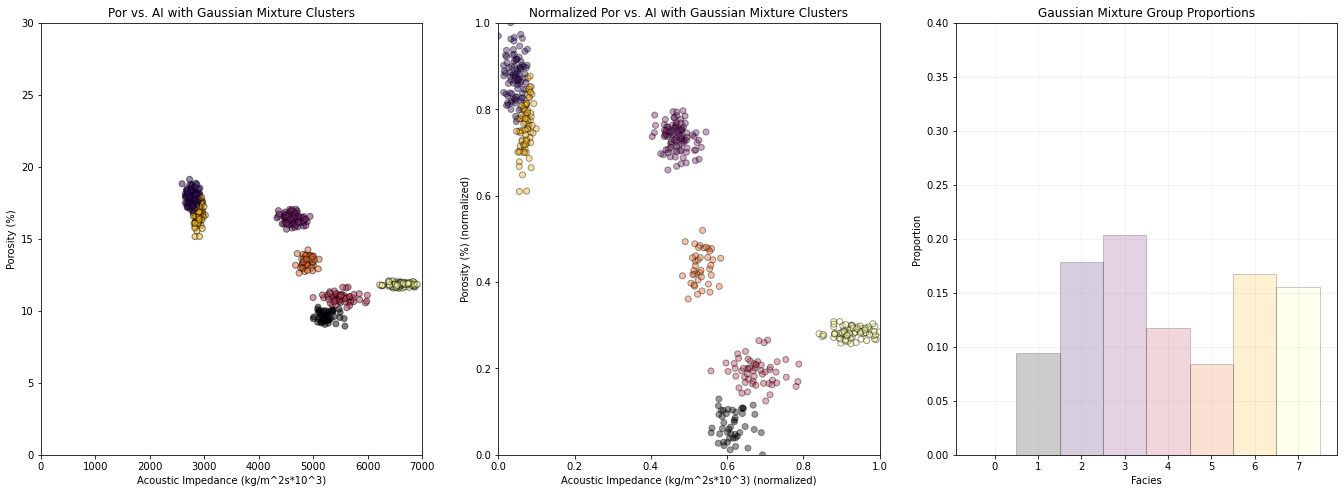

The Gaussian Mixture method clusters the spherical distribution data very well.


In [19]:
gmm = GaussianMixture(n_components = n_sample, random_state = 0).fit(df_sample[['n' + col[0],'n' + col[1]]].values)
gmm_labels = gmm.predict(df_sample[['n' + col[0],'n' + col[1]]].values)
df_sample['gmm'] = gmm_labels + 1

plt.subplot(131)                          
plt.scatter(df_sample[col[0]], df_sample[col[1]], c = df_sample['gmm'], alpha = 0.5, edgecolor = 'black', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with Gaussian Mixture Clusters')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim_sample)
plt.ylim(ylim)

plt.subplot(132)                          
plt.scatter(df_sample['n' + col[0]], df_sample['n' + col[1]], c = df_sample['gmm'], 
            alpha = 0.4, linewidths = 1.0, edgecolors = 'black', cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with Gaussian Mixture Clusters')
plt.xlabel(xlabel + ' (normalized)')
plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.2, top = 1.2, wspace = 0.2, hspace = 0.2)

plt.subplot(133)
N, bins, patches = plt.hist(df_sample['gmm'], alpha = 0.2, edgecolor = 'black',
                            bins=np.arange(-0.5, 1.5 + n_sample, 1),
                            range=[-0.5, 0.5 + n_sample], density = True)

patches[1].set_facecolor(str(cmap_color_sample[0])); patches[2].set_facecolor(str(cmap_color_sample[1]));
patches[3].set_facecolor(str(cmap_color_sample[2])); patches[4].set_facecolor(str(cmap_color_sample[3])); 
patches[5].set_facecolor(str(cmap_color_sample[4])); patches[6].set_facecolor(str(cmap_color_sample[5]));
patches[7].set_facecolor(str(cmap_color_sample[6]));

plt.title('Gaussian Mixture Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(0.0, 1.0 + n_sample, 1))
ax.set_yticks(np.arange(0, 0.45, 0.05), minor=True)

ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)

plt.show()

print('The Gaussian Mixture method clusters the spherical distribution data very well.')

## 2. Bayesian Gaussian Mixture Clustering Method
Bayesian Gaussian Mixture method allows to infer an approximate posterior distribution over the parameters of a Gaussian mixture distribution. The effective number of components can be inferred from the data.

### Bayesian Gaussian Mixture Clustering Parameter Estimation
Refer from scikit learn:　https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html

For sklearn.mixture.BayesianGaussianMixture(*, n_components = 1, covariance_type = 'full', tol = 0.001, reg_covar = 1e-06, max_iter = 100, n_init = 1, init_params = 'kmeans', weight_concentration_prior_type = 'dirichlet_process', weight_concentration_prior = None, mean_precision_prior = None, mean_prior = None, degrees_of_freedom_prior = None, covariance_prior = None, random_state = None, warm_start = False, verbose = 0, verbose_interval = 10)

The parameters of Bayesian Gaussian Misture method are almost as same as the Gaussian Miture Method. Using a theoretical information criterion, such as “Akaike information criterion (AIC)” or “bayesian information criterion (BIC)” to estimate the number of components. 

The elbow point is a good starting point, but we still need to test values around it.

Furthermore, Bayesian Gaussian Mixture consider about "Dirichlet Process". The Dirichlet process is a prior probability distribution on clusterings with an infinite, unbounded, number of partitions. Variational techniques let us incorporate this prior structure on Gaussian mixture models at almost no penalty in inference time, comparing with a finite Gaussian mixture model.

* weight_concentration_prior_type: the type of the weight concentration prior (default = 'dirichlet_process'). 

### Bayesian Gaussian Mixture Clustering
#### For Data 1: nonlinear_facies_v2.csv

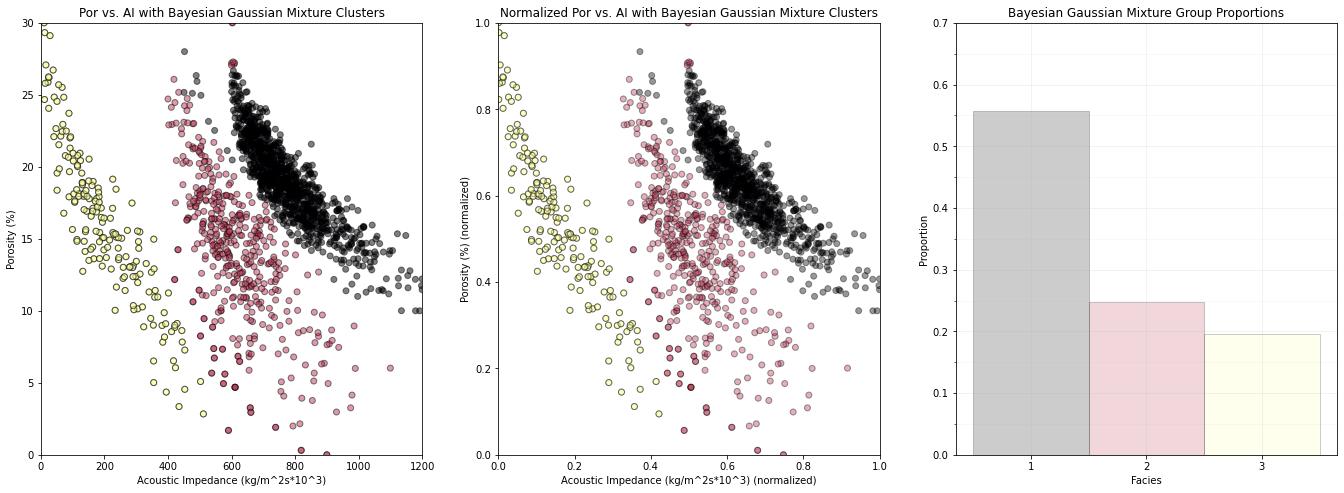

The Bayesian Gaussian Mixture method clusters the strip distribution data well.
However, it has the same problem as the Gaussian Mixture method that the data around the boundary is still challenging to cluster correctly.


In [20]:
dpgmm = BayesianGaussianMixture(n_components = n_nonlinear, 
                                random_state = 0).fit(df_nonlinear[['n'+col[0],'n'+col[1]]].values)
dpgmm_labels = dpgmm.predict(df_nonlinear[['n'+col[0],'n'+col[1]]].values)
df_nonlinear['dpgmm'] = dpgmm_labels+1

plt.subplot(131)                          # plot the assigned training data and K prototypes
plt.scatter(df_nonlinear[col[0]], df_nonlinear[col[1]], c = df_nonlinear['dpgmm'], 
            alpha = 0.5, edgecolor = 'k', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with Bayesian Gaussian Mixture Clusters')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim_nonlinear)
plt.ylim(ylim)

plt.subplot(132)                          # plot the training data and K prototypes
plt.scatter(df_nonlinear['n' + col[0]], df_nonlinear['n' + col[1]], c = df_nonlinear['dpgmm'], 
            alpha = 0.4, linewidths = 1.0, edgecolors = 'black', cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with Bayesian Gaussian Mixture Clusters')
plt.xlabel(xlabel + ' (normalized)')
plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.2, top = 1.2, wspace = 0.2, hspace = 0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df_nonlinear['dpgmm'], alpha=0.2, edgecolor = 'black', 
                             bins=np.arange(0.5, 1.5 + n_nonlinear, 1), range = [0.5, 0.5 + n_nonlinear],
                             density = True)

patches[0].set_facecolor(str(cmap_color_nonlinear[0]))
patches[1].set_facecolor(str(cmap_color_nonlinear[1]))
patches[2].set_facecolor(str(cmap_color_nonlinear[2]))

plt.title('Bayesian Gaussian Mixture Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(1.0, 1.0 + n_nonlinear, 1))
ax.set_yticks(np.arange(0, 0.75, 0.05), minor=True)

ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)

plt.show()

print('The Bayesian Gaussian Mixture method clusters the strip distribution data well.\
\nHowever, it has the same problem as the Gaussian Mixture method that \
the data around the boundary is still challenging to cluster correctly.')

#### For Data 2: sample_data_Gaussian_mixture_v1.csv

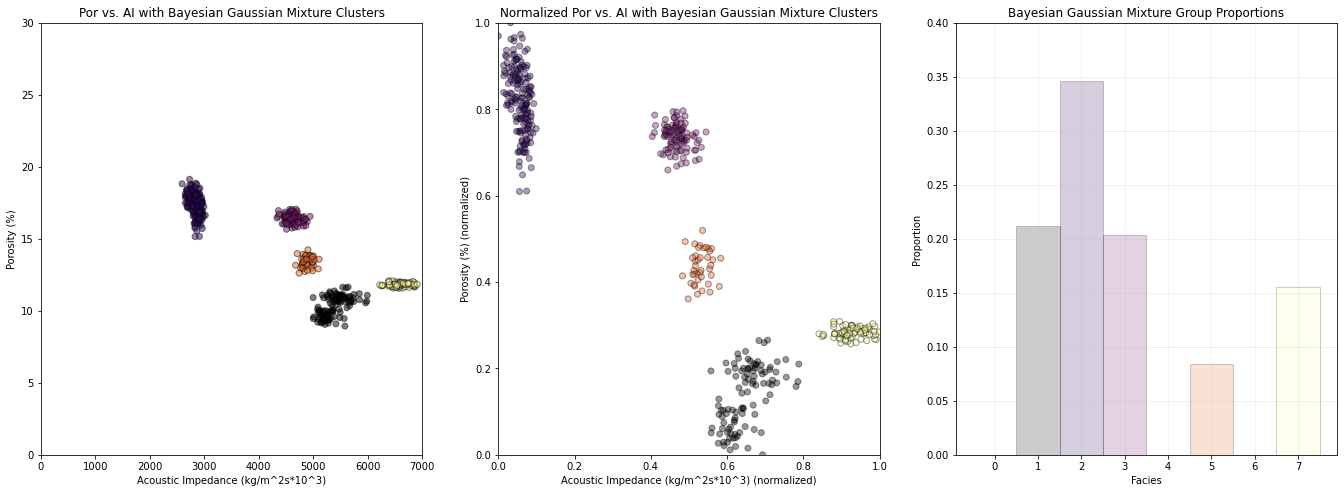

The Gaussian Mixture method clusters the spherical distribution data very well.
However, after the Dirichlet process and use the defult type of covariance, the Bayesian Gaussian Mixture method select 5 as the clustering number.


In [21]:
dpgmm = BayesianGaussianMixture(n_components = n_sample,
                                random_state = 0).fit(df_sample[['n'+col[0],'n'+col[1]]].values)
dpgmm_labels = dpgmm.predict(df_sample[['n'+col[0],'n'+col[1]]].values)
df_sample['dpgmm'] = dpgmm_labels+1

plt.subplot(131)                          # plot the assigned training data and K prototypes
plt.scatter(df_sample[col[0]], df_sample[col[1]], c = df_sample['dpgmm'], alpha = 0.5, edgecolor = 'black', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with Bayesian Gaussian Mixture Clusters')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim_sample)
plt.ylim(ylim)

plt.subplot(132)                          # plot the training data and K prototypes
plt.scatter(df_sample['n' + col[0]], df_sample['n' + col[1]], c = df_sample['dpgmm'], 
            alpha = 0.4, linewidths = 1.0, edgecolors = 'black', cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with Bayesian Gaussian Mixture Clusters')
plt.xlabel(xlabel + ' (normalized)')
plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.2, top = 1.2, wspace = 0.2, hspace = 0.2)

plt.subplot(133)
N, bins, patches = plt.hist(df_sample['dpgmm'], alpha = 0.2, edgecolor = 'black',
                            bins=np.arange(-0.5, 1.5 + n_sample, 1),
                            range=[-0.5, 0.5 + n_sample], density = True)

patches[1].set_facecolor(str(cmap_color_sample[0])); patches[2].set_facecolor(str(cmap_color_sample[1]));
patches[3].set_facecolor(str(cmap_color_sample[2])); patches[4].set_facecolor(str(cmap_color_sample[3])); 
patches[5].set_facecolor(str(cmap_color_sample[4])); patches[6].set_facecolor(str(cmap_color_sample[5]));
patches[7].set_facecolor(str(cmap_color_sample[6]));

plt.title('Bayesian Gaussian Mixture Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(0.0, 1.0 + n_sample, 1))
ax.set_yticks(np.arange(0, 0.45, 0.05), minor=True)

ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)

plt.show()

print('The Gaussian Mixture method clusters the spherical distribution data very well.\
\nHowever, after the Dirichlet process and use the defult type of covariance, \
the Bayesian Gaussian Mixture method select 5 as the clustering number.')

## 3. Agglomerative Method
Agglomerative method is a type of hierarchical clustering algorithm. It is an unsupervised machine learning technique that divides the population into several clusters such that data points in the same cluster are more similar and data points in different clusters are dissimilar.

Also, Agglomerative clustering known as bottom-up hierarchical clustering. Each object is a cluster at the beginning, and each time the two closest clusters are merged according to certain criteria to generate a new cluster, and so on. Finally, all objects belong to a cluster.

Example:
<table>
<td>
<img src = "Agglomerative step 1.png" alt = "ImageFile" style = "width:170px;" align = "left"/> <br>
</td>
<td>
<img src = "Agglomerative step 2.png" alt = "ImageFile" style = "width:300px;" align = "left"/> <br>
</td>
<td>
<img src = "Agglomerative step 3.png" alt = "ImageFile" style = "width:300px;" align = "left"/> <br>
</td>
<td>
<img src = "Agglomerative step 4.png" alt = "ImageFile" style = "width:300px;" align = "left"/> <br>
</td>
</table>

### Agglomerative Clustering Parameter Estimation
Refer from scikit learn: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

For sklearn.cluster.AgglomerativeClustering (n_clusters = 2, *, affinity = 'euclidean', memory = None, connectivity = None, compute_full_tree = 'auto', linkage = 'ward', distance_threshold = None, compute_distances = False)

* n_clusters: The number of clusters to find (default = 2).
* linkage: Which linkage criterion to use (default = 'ward')
        -ward: minimizes the variance of the clusters being merged.
        -average: uses the average of the distances of each observation of the two sets.
        -complete or maximum: linkage uses the maximum distances between all observations of the two sets.
        -single: uses the minimum of the distances between all observations of the two sets.

We can try to find the number of clusters (n_clusters) by using scipy.cluster.hierarchy.linkage, scipy.cluster.hierarchy.dendrogram, and scipy.cluster.hierarchy.fcluster.

For scipy.cluster.hierarchy.linkage (y, method = 'single', metric = 'euclidean', optimal_ordering = False)

* y: 1-D condensed distance matrix or a 2-D array of observation vectors.
* method: The linkage algorithm to use.
* metric: The distance metric to use in the case that y is a collection of observation vectors.

For scipy.cluster.hierarchy.dendrogram (Z, p = 30, truncate_mode = None, color_threshold = None, get_leaves = True, orientation = 'top', labels = None, count_sort = False, distance_sort = False, show_leaf_counts = True, no_plot = False, no_labels = False, leaf_font_size = None, leaf_rotation = None, leaf_label_func = None, show_contracted = False, link_color_func = None, ax = None, above_threshold_color = 'C0')

* Z: The linkage matrix encoding the hierarchical clustering to render as a dendrogram.
* P: The p parameter for truncate_mode.
* truncate_mode: The dendrogram can be hard to read when the original observation matrix from which the linkage is derived is large.
    -None: No truncation is performed (default).
    -lastp: The last p non-singleton clusters formed in the linkage are the only non-leaf nodes in the linkage.
    -level: No more than p levels of the dendrogram tree are displayed.
* show_leaf_counts: When True, leaf nodes representing.
* leaf_font_size: Specifies the font size of the leaf labels.

#### For Data 1: nonlinear_facies_v2.csv

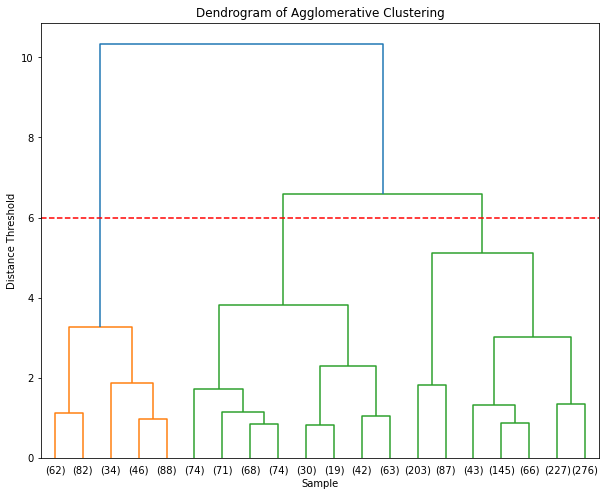

In [22]:
Z_nonlinear = linkage(df_nonlinear[['n' + col[0],'n' + col[1]]].values, method = 'ward', metric = 'euclidean')

plt.figure(figsize=(10, 8))
dendrogram(Z_nonlinear, p = 20, truncate_mode = 'lastp',  show_leaf_counts = True, leaf_font_size = 10)
plt.title('Dendrogram of Agglomerative Clustering')
plt.xlabel('Sample')
plt.ylabel("Distance Threshold")

x = np.linspace(0, 5000 , 100)
y = x * 0 + 6
plt.plot(x, y, color = 'r', linestyle = 'dashed')

plt.show()

Using fcluster to check the dendrogram results.

For scipy.cluster.hierarchy.fcluster (Z, t, criterion = 'inconsistent', depth = 2, R = None, monocrit = None)
* Z: The hierarchical clustering encoded with the matrix returned by the linkage function.
* t: scalar
        -For ‘inconsistent’, ‘distance’ or ‘monocrit’, this is the threshold to apply when forming flat clusters.
        -For ‘maxclust’ or ‘maxclust_monocrit’ criteria, this would be max number of clusters requested.
* criterion: The criterion to use in forming flat clusters.
        -inconsistent: If a cluster node and all its descendants have an inconsistent value less than or equal to t, 
                       then all its leaf descendants belong to the same flat cluster (Default).
        -distance: Forms flat clusters so that the original observations in each flat cluster have no greater a 
                   cophenetic distance than t.
        -maxclust: Finds a minimum threshold r so that the cophenetic distance between any two original observations 
                   in the same flat cluster is no more than r and no more than t flat clusters are formed.
        -monocrit: Forms a flat cluster from a cluster node c with index i when monocrit[j] <= t.
        -maxclust_monocrit: Forms a flat cluster from a non-singleton cluster node c when monocrit[i] <= r for all 
                            cluster indices i below and including c.

In [23]:
# according to the threshold to apply flat clusters.
d = 6
labels_1 = fcluster(Z_nonlinear, t = d, criterion='distance')
print('The result from distance criterion:')   # clustering result
print(labels_1[: 100])
print('The number of clusters:', len(set(labels_1)))   # count the number of clusters

# according to the number of clusters to apply flat clusters 
k = len(set(labels_1))
labels_2 = fcluster(Z_nonlinear, t = k, criterion = 'maxclust')
print('The result from maxclust criterion:')   # clustering result
print(labels_2[: 100])

# Check if the clustering results are consistent
print('Are the clustering results consistent:', list(labels_1) == list(labels_2))  

The result from distance criterion:
[2 1 1 1 1 2 2 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1]
The number of clusters: 3
The result from maxclust criterion:
[2 1 1 1 1 2 2 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1]
Are the clustering results consistent: True


Since we have the actual facies data, we can use adjusted mutual information to evaluate which linkage method is more suitable to cluster the dataset. If the value is closer to 1, the clustering algorithm is closer to the real situation. 

For sklearn.metrics.adjusted_mutual_info_score(labels_true, labels_pred, *, average_method = 'arithmetic')
* labels_true: Actual clustering data.
* labels_pred: predictor clustering data.

method single:
Adjust mutual information: 0.001
time used: 0.037 seconds
method complete:
Adjust mutual information: 0.023
time used: 0.055 seconds
method average:
Adjust mutual information: 0.559
time used: 0.055 seconds
method ward:
Adjust mutual information: 0.736
time used: 0.060 seconds


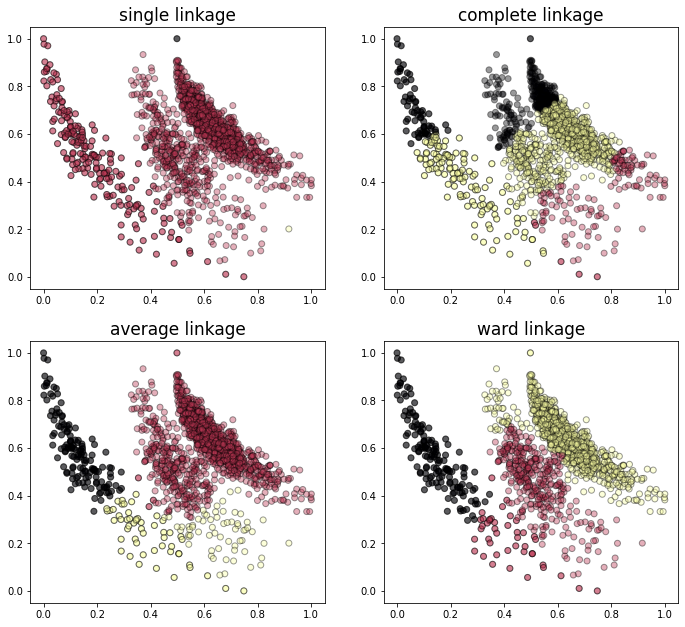

In [24]:
X = df_nonlinear[['n'+col[0],'n'+col[1]]].values
labels_nonlinear = df_nonlinear[col[2]]

linkage_method_list = ['single', 'complete', 'average', 'ward']

ncols, nrows = 2, int(np.ceil(len(linkage_method_list) / 2))

for i, linkage_method in enumerate(linkage_method_list):
    print('method %s:' % linkage_method)
    start_time = time()
    Z_nonlinear = linkage(X, method = linkage_method)
    labels_pred_nonlinear = fcluster(Z_nonlinear, t = n_nonlinear, criterion = 'maxclust')
    print('Adjust mutual information: %.3f' % adjusted_mutual_info_score(labels_nonlinear, labels_pred_nonlinear))
    print('time used: %.3f seconds' % (time() - start_time))
    plt.subplot(nrows, ncols, i + 1)
    plot_clustering(X, labels_pred_nonlinear, '%s linkage' % linkage_method)
    plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 1.5, top = 2.0, wspace = 0.2, hspace = 0.2)

plt.show()

#### For Data 2: sample_data_Gaussian_mixture_v1.csv

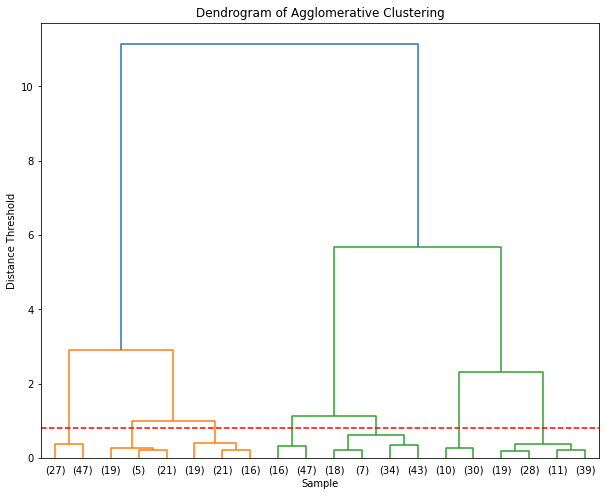

In [25]:
Z_sample = linkage(df_sample[['n' + col[0],'n' + col[1]]].values, method = 'ward', metric = 'euclidean')

plt.figure(figsize=(10, 8))
dendrogram(Z_sample, p = 20, truncate_mode = 'lastp',  show_leaf_counts = True, leaf_font_size = 10)
plt.title('Dendrogram of Agglomerative Clustering')
plt.xlabel('Sample')
plt.ylabel("Distance Threshold")

x = np.linspace(0, 5000 , 100)
y = x * 0 + 0.8
plt.plot(x, y, color = 'r', linestyle = 'dashed')

plt.show()

In [26]:
# according to the threshold to apply flat clusters.
d = 0.8
labels_1 = fcluster(Z_sample, t = d, criterion = 'distance')
print('The result from distance criterion:')   # clustering result
print(labels_1[: 100])
print('The number of clusters:', len(set(labels_1)))   # count the number of clusters

# according to the number of clusters to apply flat clusters 
k = len(set(labels_1))
labels_2 = fcluster(Z_sample, t = k, criterion = 'maxclust')
print('The result from maxclust criterion:')   # clustering result
print(labels_2[: 100])

# Check if the clustering results are consistent
print('Are the clustering results consistent:', list(labels_1) == list(labels_2))  

The result from distance criterion:
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 4 4 5 5 5 5 5 5 5 4 5 5 5 5 5 4 5 5 5 5 5 5
 5 5 4 5 5 5 5 5 5 4 5 4 5 5 5 5 5 4 5 5 4 4 4 4 4 4]
The number of clusters: 7
The result from maxclust criterion:
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 4 4 5 5 5 5 5 5 5 4 5 5 5 5 5 4 5 5 5 5 5 5
 5 5 4 5 5 5 5 5 5 4 5 4 5 5 5 5 5 4 5 5 4 4 4 4 4 4]
Are the clustering results consistent: True


method single:
Adjust mutual information: 0.878
time used: 0.006 seconds
method complete:
Adjust mutual information: 0.906
time used: 0.007 seconds
method average:
Adjust mutual information: 0.927
time used: 0.007 seconds
method ward:
Adjust mutual information: 0.912
time used: 0.008 seconds


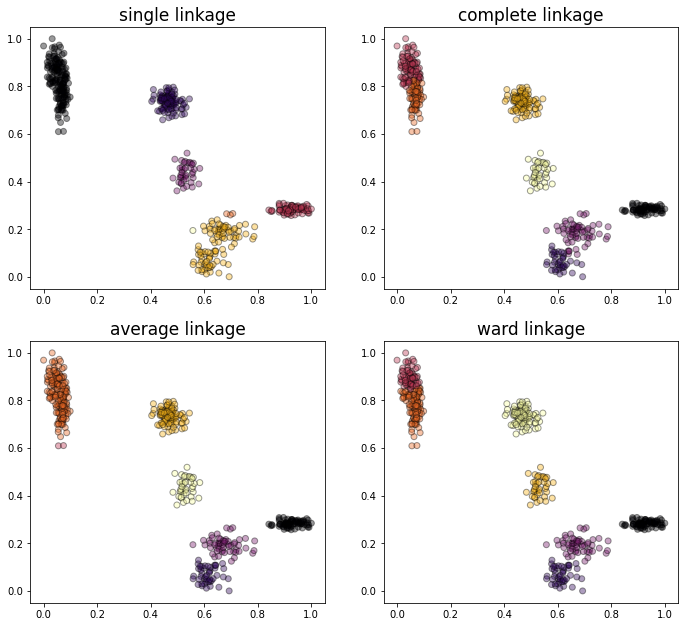

In [27]:
X = df_sample[['n'+col[0],'n'+col[1]]].values
labels = df_sample[col[2]]

linkage_method_list = ['single', 'complete', 'average', 'ward']

ncols, nrows = 2, int(np.ceil(len(linkage_method_list) / 2))

for i, linkage_method in enumerate(linkage_method_list):
    print('method %s:' % linkage_method)
    start_time = time()
    Z = linkage(X, method = linkage_method)
    labels_pred = fcluster(Z, t = n_sample, criterion = 'maxclust')
    print('Adjust mutual information: %.3f' % adjusted_mutual_info_score(labels, labels_pred))
    print('time used: %.3f seconds' % (time() - start_time))
    plt.subplot(nrows, ncols, i + 1)
    plot_clustering(X, labels_pred, '%s linkage' % linkage_method)
    plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 1.5, top = 2.0, wspace = 0.2, hspace = 0.2)

plt.show()

### Agglomerative Clustering
#### For Data 1: nonlinear_facies_v2.csv

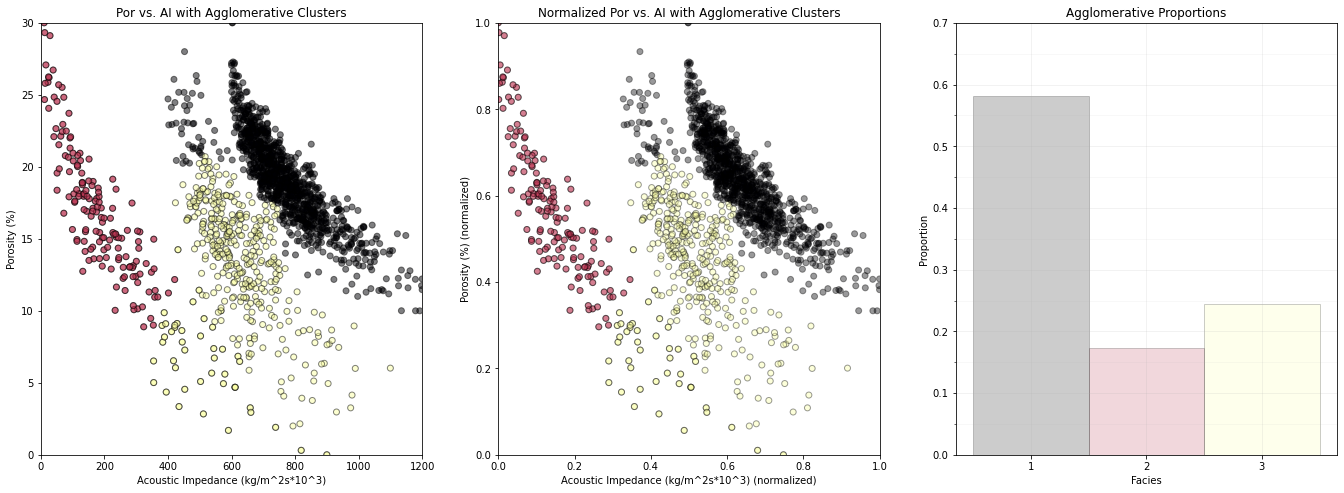

The Agglomerative method clusters the strip distribution data is OK.
However, the data around the polar is still challenging to cluster correctly.


In [28]:
agg = AgglomerativeClustering(n_clusters = n_nonlinear, linkage = 'ward').fit(df_nonlinear[['n' + col[0],
                                                                                            'n' + col[1]]].values)
df_nonlinear['agg'] = agg.labels_ + 1

plt.subplot(131)                          
plt.scatter(df_nonlinear[col[0]], df_nonlinear[col[1]], c = df_nonlinear['agg'],
            alpha = 0.5, edgecolor = 'k', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with Agglomerative Clusters')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim_nonlinear)
plt.ylim(ylim)

plt.subplot(132)                          
plt.scatter(df_nonlinear['n' + col[0]], df_nonlinear['n' + col[1]], c = df_nonlinear['agg'], 
            alpha = 0.4, linewidths = 1.0, edgecolors = 'black', cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with Agglomerative Clusters')
plt.xlabel(xlabel + ' (normalized)')
plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.2, top = 1.2, wspace = 0.2, hspace = 0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df_nonlinear['agg'], alpha=0.2, edgecolor = 'black', 
                             bins=np.arange(0.5, 1.5 + n_nonlinear, 1), range = [0.5, 0.5 + n_nonlinear],
                             density = True)

patches[0].set_facecolor(str(cmap_color_nonlinear[0]))
patches[1].set_facecolor(str(cmap_color_nonlinear[1]))
patches[2].set_facecolor(str(cmap_color_nonlinear[2]))

plt.title('Agglomerative Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(1.0, 1.0 + n_nonlinear, 1))
ax.set_yticks(np.arange(0, 0.75, 0.05), minor = True)

ax.grid(which = 'minor', alpha = 0.1)
ax.grid(which = 'major', alpha = 0.2)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.0, top = 1.50, wspace = 0.2, hspace = 0.2)

plt.show()

print('The Agglomerative method clusters the strip distribution data is OK.\
\nHowever, the data around the polar is still challenging to cluster correctly.')

#### For Data 2: sample_data_Gaussian_mixture_v1.csv

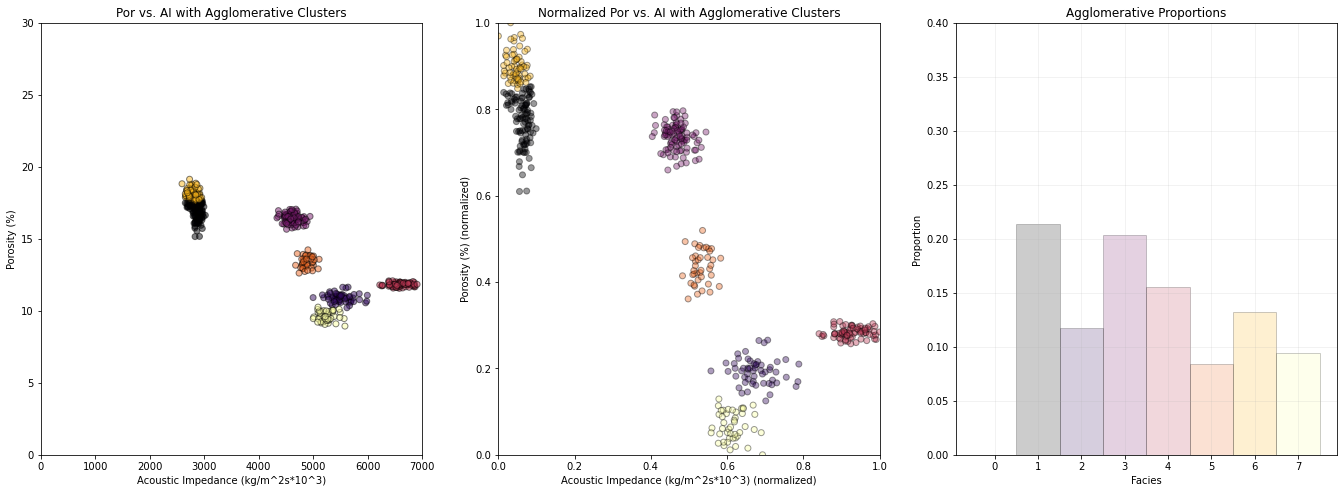

The Agglomerative method clusters the strip distribution data well.
However, I choose "ward" as the linkage method instead of "average" even though the averagehas a higher adjust mutual information score. I determine this based on the visualization of clustering. Using ward linkage, we can obtain more accurate clustering in the upper left corner.


In [29]:
agg = AgglomerativeClustering(n_clusters = n_sample, linkage = 'ward').fit(df_sample[['n' + col[0],
                                                                                         'n' + col[1]]].values)
df_sample['agg'] = agg.labels_ + 1

plt.subplot(131)                          
plt.scatter(df_sample[col[0]], df_sample[col[1]], c = df_sample['agg'],
            alpha = 0.5, edgecolor = 'k', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with Agglomerative Clusters')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim_sample)
plt.ylim(ylim)

plt.subplot(132)                          
plt.scatter(df_sample['n' + col[0]], df_sample['n' + col[1]], c = df_sample['agg'], 
            alpha = 0.4, linewidths = 1.0, edgecolors = 'black', cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with Agglomerative Clusters')
plt.xlabel(xlabel + ' (normalized)')
plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 3.2, top = 1.2, wspace = 0.2, hspace = 0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df_sample['agg'], alpha=0.2, edgecolor = 'black', 
                             bins=np.arange(-0.5, 1.5 + n_sample, 1), 
                             range=[-0.5, 0.5 + n_sample], density = True)

patches[1].set_facecolor(str(cmap_color_sample[0])); patches[2].set_facecolor(str(cmap_color_sample[1]));
patches[3].set_facecolor(str(cmap_color_sample[2])); patches[4].set_facecolor(str(cmap_color_sample[3])); 
patches[5].set_facecolor(str(cmap_color_sample[4])); patches[6].set_facecolor(str(cmap_color_sample[5]));
patches[7].set_facecolor(str(cmap_color_sample[6]));

plt.title('Agglomerative Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(0.0, 1.0 + n_sample, 1))
ax.set_yticks(np.arange(0, 0.45, 0.05), minor=True)

ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)

plt.show()

print('The Agglomerative method clusters the strip distribution data well.')
print('However, I choose "ward" as the linkage method instead of "average" even though the average\
has a higher adjust mutual information score. I determine this based on the visualization of clustering.\
 Using ward linkage, we can obtain more accurate clustering in the upper left corner.')

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)